<a href="https://colab.research.google.com/github/Bhavana-Kolli/22035573_Ass3_LLM/blob/main/22035573_Ass3_LLM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [1]:
# install transformers
!pip install transformers datasets torch seqeval

# import clear out to clear output during library installation
from IPython.display import clear_output
clear_output()

In [2]:
# here modules are imported
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import math
import tensorflow as tf
import transformers
import tensorflow_datasets as tfds
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import TrainingArguments, Trainer
from datasets import load_dataset
from seqeval.metrics import f1_score, accuracy_score
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import DataCollatorForTokenClassification


# **Functions Used Here**

In [3]:

# Function to tokenize the inputs and align the NER tags with the subword tokens

def tokenize_and_align_labels(examples):
    """

    Args:
      examples:

    Returns:

    """
    tokenized_inputs = tokenizer_ner(
        examples['tokens'],
        truncation=True,
        is_split_into_words=True
    )

    labels = []
    for i, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        aligned_labels = []
        previous_word_idx = None

        for word_idx in word_ids:
            if word_idx is None:  # Special tokens
                aligned_labels.append(-100)
            elif word_idx != previous_word_idx:  # First subword
                aligned_labels.append(label[word_idx])
            else:  # Subsequent subwords
                aligned_labels.append(-100)
            previous_word_idx = word_idx

        labels.append(aligned_labels)

    tokenized_inputs['labels'] = labels
    return tokenized_inputs


# Function to display the inferences from our model
def inferences_ner(sentence, model_ner, tokenizer_ner, label_names):
    """

    Args:
      sentence:

    """
    # Create a NER pipeline
    ner_pipeline = pipeline('ner', model=model_ner, tokenizer=tokenizer_ner, aggregation_strategy="simple")

    # Create label mapping
    label_map = {i: label.split('-')[-1] for i, label in enumerate(label_names)}

    # Perform NER
    ner_results = ner_pipeline(sentence)

    # Print each entity with its label
    for entity in ner_results:
        label = label_map[int(entity['entity_group'].split('_')[-1])]
        if label != "O":
            print(f"{entity['word']} -> {label}")

# **Loading Dataset**

In [4]:

# Load the CoNLL-2003 dataset
conll_data = load_dataset('conll2003', trust_remote_code=True)

# print the dataset
print(conll_data)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


In [5]:
# Display a sample from the training set to understand its structure
sample = conll_data['train'][0]
print(sample)

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


In [6]:
# Display the features of the dataset, which include tokens (words in the sentence) and ner_tags (corresponding NER labels).
print(conll_data['train'].features)


{'id': Value(dtype='string', id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'pos_tags': Sequence(feature=ClassLabel(names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None), 'chunk_tags': Sequence(feature=ClassLabel(names=['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP'], id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)}


In [7]:
# Extracting tokens and labels from the sample
tokens = sample['tokens']
ner_tags = sample['ner_tags']
label_names = conll_data['train'].features['ner_tags'].feature.names

# Display the tokens and corresponding labels
print(f"Tokens: {tokens}")
print(f"NER Tags: {[label_names[tag] for tag in ner_tags]}")

Tokens: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
NER Tags: ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


# **Preprocessing Data**

In [8]:
# Load the BERT tokenizer
tokenizer_ner = AutoTokenizer.from_pretrained('bert-base-cased')


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [9]:
# Display a tokenized example to understand the tokenization process
example = conll_data['train'][0]
print(f"Original tokens: {example['tokens']}")
tokenized_example = tokenizer_ner(example['tokens'], truncation=True, is_split_into_words=True)
print(f"Tokenized tokens: {tokenized_example.tokens()}")


Original tokens: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
Tokenized tokens: ['[CLS]', 'EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'la', '##mb', '.', '[SEP]']


In [10]:
# Applying the tokenization and label alignment function to the dataset
tokenized_datasets = conll_data.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [11]:

# Create a data collator that handles padding for both inputs and labels
data_collator = DataCollatorForTokenClassification(tokenizer_ner)

# Check the processed dataset structure
print(tokenized_datasets['train'][0])


{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0], 'input_ids': [101, 7270, 22961, 1528, 1840, 1106, 21423, 1418, 2495, 12913, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 3, 0, 7, 0, 0, 0, 7, 0, -100, 0, -100]}


# **Train & Fine-tune Model**

In [12]:
# Now we fine-tune the BERT model for the NER task using Hugging Face’s Trainer API.

# Load the BERT model for token classification
model_ner = AutoModelForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(label_names))

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=3,
    save_steps=10_000,
    save_total_limit=2,
    logging_dir='./logs',
    logging_steps=10,  # Log every 10 steps
    fp16=True,
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:

# Initialize the Trainer
trainer_ner = Trainer(
    model=model_ner,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer_ner,
    data_collator=data_collator,
)



In [14]:
# Start training
trainer_ner.train()

Epoch,Training Loss,Validation Loss
1,0.081900,0.073062
2,0.046000,0.048434
3,0.033700,0.044869


TrainOutput(global_step=330, training_loss=0.16432129912304155, metrics={'train_runtime': 30.3122, 'train_samples_per_second': 1389.639, 'train_steps_per_second': 10.887, 'total_flos': 1385865353907198.0, 'train_loss': 0.16432129912304155, 'epoch': 3.0})

# **Evaluate**

In [15]:
# Evaluate the model
metrics = trainer_ner.evaluate()
print(metrics)

{'eval_loss': 0.0448685958981514, 'eval_runtime': 0.7946, 'eval_samples_per_second': 4090.193, 'eval_steps_per_second': 32.722, 'epoch': 3.0}


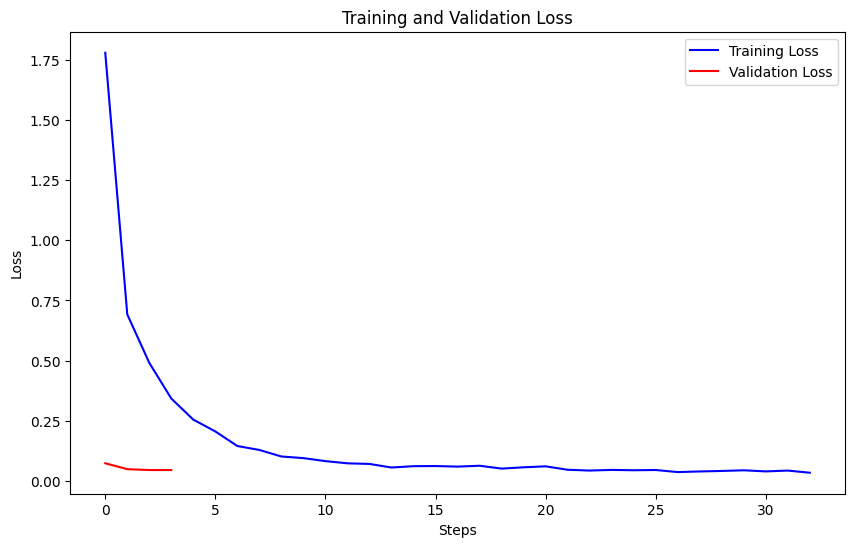

In [16]:
# Extract loss values from the training logs
training_logs = trainer_ner.state.log_history

train_losses = [log["loss"] for log in training_logs if "loss" in log]
val_losses = [log["eval_loss"] for log in training_logs if "eval_loss" in log]

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, 'b', label='Training Loss')
plt.plot(val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Inference**

In [17]:
# Inferences
inferences_ner("EU rejects German call to boycott British lamb.", model_ner, tokenizer_ner, label_names)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


EU -> ORG
German -> MISC
British -> MISC


In [18]:
inferences_ner("Iraq's Saddam meets Russia's Zhiro.", model_ner, tokenizer_ner, label_names)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Iraq -> LOC
Saddam -> PER
Russia -> LOC
Zhiro -> PER


In [19]:
inferences_ner("Robin is winding up his term as ambassador", model_ner, tokenizer_ner, label_names)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Robin -> PER


In [23]:
inferences_ner("Jay is from India", model_ner, tokenizer_ner, label_names)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Jay -> PER
India -> LOC
